In [13]:
%matplotlib inline

Character-Level RNN Classifier
**************************************************************
**Credits to:** `Sean Robertson <https://github.com/spro/practical-pytorch>`

Modified by Gu Yucheng (Enoch2090)


## Commands for Colab

In [30]:
# !rm data -r

In [31]:
# !mkdir data

## Import & Utils

In [20]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/power.txt', 'data/exterior.txt', 'data/configuration.txt', 'data/price.txt']


Turning Names into Tensors
--------------------------




In [21]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('horsepower').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([10, 1, 57])


Creating the Network
====================






In [22]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [23]:
rnn.load_state_dict(torch.load('../feature_predictor.pt')) 

<All keys matched successfully>

In [24]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [25]:
input = lineToTensor('high horsepower')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-1.4441, -1.3618, -1.2249, -1.5416]], grad_fn=<LogSoftmaxBackward0>)


Training
========
Preparing for Training



In [37]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('configuration', 2)


In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = power / line = check engine
category = exterior / line = normal black
category = price / line = dollars cheap
category = power / line = GTR engine
category = price / line = sale price
category = power / line = broken engine
category = price / line = internet price
category = exterior / line = cost red
category = configuration / line = heated seat
category = exterior / line = WR blue


Training the Network




In [39]:
criterion = nn.NLLLoss()

In [40]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [41]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    try:
        output, loss = train(category_tensor, line_tensor)
        current_loss += loss
    except:
        print(category, line)

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

power 
configuration 
power 
5000 5% (0m 11s) 0.3756 car cheap / price ✓
power 
power 
price 
10000 10% (0m 21s) 0.0014 prefer black / exterior ✓
configuration 
power 
power 
15000 15% (0m 32s) 0.0003 ecoboost engine / power ✓
exterior 
power 
power 
20000 20% (0m 43s) 0.0017 cloth seat / configuration ✓
exterior 
power 
power 
25000 25% (0m 53s) 0.0001 blown engine / power ✓
power 
30000 30% (1m 4s) 0.0004 kelly blue / exterior ✓
power 
35000 35% (1m 14s) 0.0002 heated seat / configuration ✓
power 
40000 40% (1m 25s) 0.0000 DOHC engine / power ✓
configuration 
power 
45000 45% (1m 35s) 0.0001 reasonable price / price ✓
power 
power 
50000 50% (1m 46s) 0.0001 leather seat / configuration ✓
exterior 
power 
55000 55% (1m 56s) 0.0005 tight budget / price ✓
power 
power 
price 
60000 60% (2m 7s) 0.0000 fair price / price ✓
power 
power 
65000 65% (2m 17s) 0.0010 advanced technology / configuration ✓
power 
price 
power 
power 
70000 70% (2m 28s) 0.0007 big diesel / power ✓
power 
power 
c

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

NameError: name 'all_losses' is not defined

<Figure size 432x288 with 0 Axes>

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




/Users/enoch/anaconda3/envs/SI650/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/enoch/anaconda3/envs/SI650/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


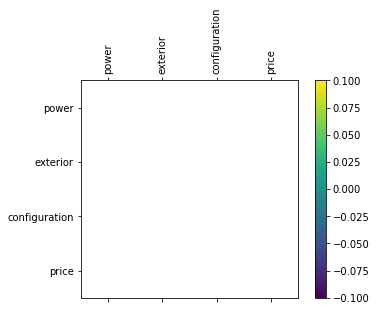

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    try:
        output = evaluate(line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1
    except:
        pass

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Running on User Input
---------------------




In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('high horsepower')
predict('luxury interior')
predict('bluetooth stereo')
predict('affordable price')


> high horsepower
(-0.00) power
(-7.64) price
(-7.82) configuration

> luxury interior
(-0.00) power
(-5.81) price
(-6.46) configuration

> bluetooth stereo
(-0.00) configuration
(-9.95) power
(-10.94) price

> affordable price
(-0.00) price
(-10.81) configuration
(-11.73) exterior


In [17]:
predict('affordable')


> affordable
(-0.02) power
(-3.80) configuration
(-7.48) price


In [18]:
predict('cheap')


> cheap
(-0.00) price
(-6.57) configuration
(-8.28) power


In [19]:
predict('blue SUV')


> blue SUV
(-0.00) exterior
(-9.59) power
(-12.60) configuration


In [48]:
# save model to file
torch.save(rnn.state_dict(), "feature_predictor.pt")